In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load necessary data
risk_scores = pd.read_csv('../data/processed/employee_risk_scores.csv')
employees_df = pd.read_csv('../data/processed/employees_engineered.csv')
recruitment_costs = pd.read_csv('../data/raw/recruitment_costs.csv')

In [3]:
risk_scores.head()

,EmployeeID,Department,JobLevel,AttritionProbability,RiskCategory
0,10001,Sales,Entry Level,0.757448,High
1,10002,Sales,Senior,0.575459,Medium
2,10003,Customer Service,Entry Level,0.336296,Low
3,10004,Operations,Senior,0.502495,Medium
4,10005,Operations,Director,0.101159,Very Low


In [4]:
employees_df.head()

,EmployeeID,FirstName,LastName,Age,Gender,OfficeLocation,DistanceFromHome,Department,JobRole,JobLevel,...,OverallSatisfaction,EngagementScore,StagnationRisk,CareerVelocity,HighPerformer,LowPerformer,IncomeToAgeRatio,TrainingEngagement,EducationLevel,AgeGroup
0,10001,Tuti,Hidayat,25,Male,Jakarta,12.41,Sales,Sales Representative,Entry Level,...,4.266667,3.633333,0,1.000000,0,0,0.156400,High,2,20s
1,10002,Yanto,Purnama,46,Male,Jakarta,8.59,Sales,Branch Sales Supervisor,Senior,...,2.833333,2.916667,0,1.877934,0,0,0.940870,Low,3,40s
2,10003,Farida,Utama,39,Female,Surabaya,8.84,Customer Service,Customer Service Representative,Entry Level,...,3.333333,3.166667,0,0.724638,0,0,0.136667,Medium,3,30s
3,10004,Dedi,Purnama,54,Male,Depok,15.93,Operations,Operations Supervisor,Senior,...,3.400000,3.700000,1,1.269841,1,0,1.027963,High,1,50+
4,10005,Edi,Habibie,24,Female,Palembang,15.72,Operations,Regional Operations Director,Director,...,3.600000,3.800000,0,6.000000,1,0,3.422917,Low,3,20s


In [5]:
recruitment_costs.head()

,JobLevel,AverageAnnualSalary,TotalRecruitmentCost,RecruitmentCostPct,AdvertisingCost,AgencyFees,InterviewCosts,AssessmentCosts,AdministrativeCosts,RelocationCosts,SigningBonus
0,Entry Level,74750000.0,1.148254e+07,15.36,1387964.34,5892994.17,2065439.35,916160.78,1219982.21,0.00,0.00
1,Junior,149500000.0,2.497653e+07,16.71,5852797.41,10261356.14,4430154.58,2680866.77,1751355.26,0.00,0.00
2,Mid-Level,260000000.0,4.674586e+07,17.98,4797546.49,21895841.95,4955668.23,6052742.87,3586971.72,278802.46,5178281.80
3,Senior,422500000.0,1.045846e+08,24.75,16032264.63,38009220.31,15263097.46,6882189.54,9311819.98,9044209.71,10041812.03
4,Manager,650000000.0,1.571372e+08,24.17,24954534.37,61319844.99,24933898.04,17481687.65,9742942.81,9629.00,18694614.24


In [20]:
# Define cost components function
def calculate_attrition_costs(employee, recruitment_costs_df):
    """Calculate the full financial impact of an employee's departure"""
    
    job_level = employee['JobLevel']
    monthly_salary = employee['MonthlyIncome']
    department = employee['Department']
    
    # 1. Direct replacement costs
    # Pull from recruitment_costs table based on job level
    recruitment_cost = recruitment_costs_df.loc[
        recruitment_costs_df['JobLevel'] == job_level, 
        'TotalRecruitmentCost'
    ].values[0]
    
    # 2. Lost productivity costs
    # Calculate based on vacancy period and productivity loss
    vacancy_duration = {
        'Entry Level': 1.0,     # months
        'Junior': 1.5,
        'Mid-Level': 2.0,
        'Senior': 3.0,
        'Manager': 4.0,
        'Director': 5.0,
        'Executive': 6.0
    }
    
    # Productivity lost during vacancy (100% of salary)
    vacancy_months = vacancy_duration.get(job_level, 2.0)
    vacancy_cost = monthly_salary * vacancy_months
    
    # 3. Onboarding & Training costs
    # New hire productivity ramp-up: 25% in first month, 50% second month, 75% third month, 100% thereafter
    if job_level in ['Entry Level', 'Junior']:
        ramp_up_months = 2
    elif job_level in ['Mid-Level', 'Senior']:
        ramp_up_months = 3
    else:  # Manager, Director, Executive
        ramp_up_months = 6
        
    ramp_up_loss = 0
    for month in range(1, ramp_up_months + 1):
        productivity_pct = min(1.0, 0.25 * month)
        ramp_up_loss += monthly_salary * (1 - productivity_pct)
    
    # 4. Knowledge transfer costs
    knowledge_transfer_days = {
        'Entry Level': 3,
        'Junior': 5,
        'Mid-Level': 10,
        'Senior': 15,
        'Manager': 20,
        'Director': 25,
        'Executive': 30
    }
    
    kt_days = knowledge_transfer_days.get(job_level, 10)
    daily_rate = monthly_salary / 22  # working days per month
    knowledge_transfer_cost = kt_days * daily_rate
    
    # 5. Team impact costs (reduced productivity of team members)
    # Assume team size varies by level and impact lasts 1-3 months
    team_sizes = {
        'Entry Level': 0,  # No direct reports
        'Junior': 0,
        'Mid-Level': 1,
        'Senior': 3,
        'Manager': 7,
        'Director': 15,
        'Executive': 30
    }
    
    team_size = team_sizes.get(job_level, 0)
    # Assume 5% productivity loss for team members during transition
    team_impact_months = min(3, vacancy_months + 1)
    avg_team_salary = monthly_salary * 0.7  # Estimate for team members' salaries
    team_impact_cost = team_size * avg_team_salary * team_impact_months * 0.05
    
    # 6. Customer impact costs (mostly for customer-facing roles)
    customer_impact = 0
    if department in ['Sales', 'Customer Service']:
        # Estimate 10% of annual salary for customer impact
        customer_impact = monthly_salary * 1.2
    
    # 7. Opportunity costs (projects delayed, opportunities missed)
    opportunity_cost = {
        'Entry Level': monthly_salary * 0.5,
        'Junior': monthly_salary * 1.0,
        'Mid-Level': monthly_salary * 2.0,
        'Senior': monthly_salary * 3.0,
        'Manager': monthly_salary * 5.0,
        'Director': monthly_salary * 8.0,
        'Executive': monthly_salary * 12.0
    }
    
    opp_cost = opportunity_cost.get(job_level, monthly_salary * 2.0)
    
    # Calculate total cost
    total_cost = (
        recruitment_cost +
        vacancy_cost +
        ramp_up_loss +
        knowledge_transfer_cost +
        team_impact_cost +
        customer_impact +
        opp_cost
    )
    
    return {
        'RecruitmentCost': recruitment_cost,
        'VacancyCost': vacancy_cost,
        'RampUpCost': ramp_up_loss,
        'KnowledgeTransferCost': knowledge_transfer_cost,
        'TeamImpactCost': team_impact_cost,
        'CustomerImpactCost': customer_impact,
        'OpportunityCost': opp_cost,
        'TotalCost': total_cost
    }

In [21]:
# Merge risk scores with employee data
analysis_df = pd.merge(
    risk_scores,
    employees_df[['EmployeeID', 'Department', 'JobLevel', 'MonthlyIncome']],
    on='EmployeeID',
    suffixes=('_drop', ''),
    how='left'
)

In [24]:
analysis_df.head(10)

,EmployeeID,Department_drop,JobLevel_drop,AttritionProbability,RiskCategory,Department,JobLevel,MonthlyIncome
0,10001,Sales,Entry Level,0.757448,High,Sales,Entry Level,3.91
1,10002,Sales,Senior,0.575459,Medium,Sales,Senior,43.28
2,10003,Customer Service,Entry Level,0.336296,Low,Customer Service,Entry Level,5.33
3,10004,Operations,Senior,0.502495,Medium,Operations,Senior,55.51
4,10005,Operations,Director,0.101159,Very Low,Operations,Director,82.15
5,10006,Sales,Manager,0.216768,Low,Sales,Manager,58.56
6,10007,HR,Mid-Level,0.294552,Low,HR,Mid-Level,26.73
7,10008,Sales,Entry Level,0.350172,Low,Sales,Entry Level,6.81
8,10009,Customer Service,Entry Level,0.367510,Low,Customer Service,Entry Level,7.66
9,10010,Sales,Senior,0.247358,Low,Sales,Senior,40.45


In [25]:
# Apply cost calculator to each employee
cost_components = []
for _, employee in analysis_df.iterrows():
    costs = calculate_attrition_costs(employee, recruitment_costs)
    costs['EmployeeID'] = employee['EmployeeID']
    costs['AttritionProbability'] = employee['AttritionProbability'] 
    costs['Department'] = employee['Department']
    costs['JobLevel'] = employee['JobLevel']
    cost_components.append(costs)

attrition_costs_df = pd.DataFrame(cost_components)

# Calculate expected costs (probability × cost)
attrition_costs_df['ExpectedCost'] = attrition_costs_df['AttritionProbability'] * attrition_costs_df['TotalCost']

# Calculate department and job level summaries
dept_costs = attrition_costs_df.groupby('Department').agg(
    TotalEmployees=('EmployeeID', 'count'),
    AvgAttritionRisk=('AttritionProbability', 'mean'),
    TotalExpectedCost=('ExpectedCost', 'sum'),
    AvgCostPerEmployee=('ExpectedCost', 'mean')
).sort_values('TotalExpectedCost', ascending=False)

level_costs = attrition_costs_df.groupby('JobLevel').agg(
    TotalEmployees=('EmployeeID', 'count'),
    AvgAttritionRisk=('AttritionProbability', 'mean'),
    TotalExpectedCost=('ExpectedCost', 'sum'),
    AvgCostPerEmployee=('ExpectedCost', 'mean')
).sort_values('TotalExpectedCost', ascending=False)

In [26]:
print("Attrition Cost Analysis by Department:")
display(dept_costs)

print("\nAttrition Cost Analysis by Job Level:")
display(level_costs)

Attrition Cost Analysis by Department:


,TotalEmployees,AvgAttritionRisk,TotalExpectedCost,AvgCostPerEmployee
Department,,,,
Sales,945,0.431288,5.827340e+10,6.166497e+07
Collections,738,0.434478,3.356310e+10,4.547845e+07
Operations,602,0.376699,2.534922e+10,4.210834e+07
Customer Service,412,0.429841,1.346429e+10,3.268030e+07
Risk Management,341,0.434138,1.046159e+10,3.067916e+07
Finance,333,0.412281,8.480725e+09,2.546764e+07
IT,224,0.368599,7.431780e+09,3.317759e+07
HR,146,0.397187,6.728192e+09,4.608351e+07
Executive,69,0.312500,3.605972e+09,5.226046e+07



Attrition Cost Analysis by Job Level:


,TotalEmployees,AvgAttritionRisk,TotalExpectedCost,AvgCostPerEmployee
JobLevel,,,,
Manager,1127,0.419441,7.428066e+10,6.591008e+07
Director,399,0.337205,4.253622e+10,1.066071e+08
Senior,594,0.464513,2.885717e+10,4.858109e+07
Mid-Level,761,0.429248,1.526996e+10,2.006565e+07
Entry Level,904,0.398406,4.135547e+09,4.574720e+06
Executive,16,0.270589,2.778509e+09,1.736568e+08
Junior,91,0.412617,9.378239e+08,1.030576e+07



Total expected attrition cost across the organization: 168,795,881,005 IDR
Average expected cost per employee: 43,369,959 IDR


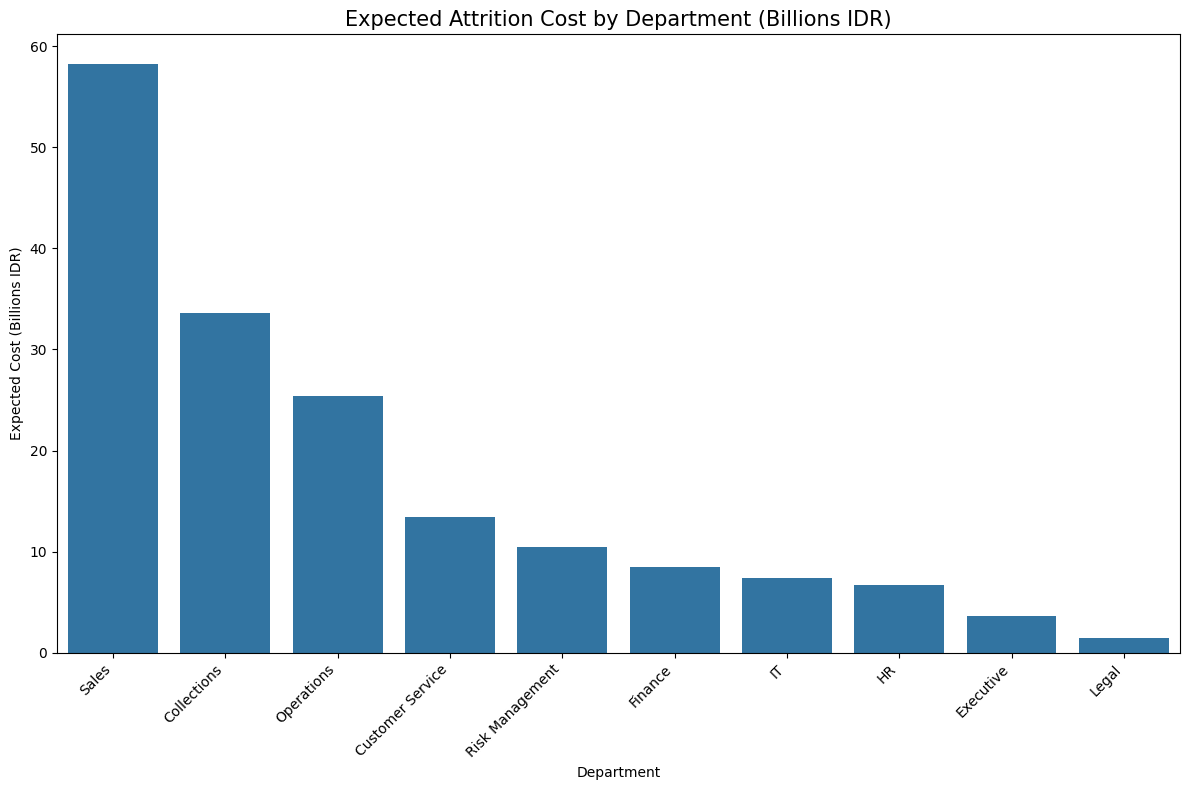

In [27]:
# Overall statistics
total_expected_cost = attrition_costs_df['ExpectedCost'].sum()
print(f"\nTotal expected attrition cost across the organization: {total_expected_cost:,.0f} IDR")
print(f"Average expected cost per employee: {total_expected_cost/len(attrition_costs_df):,.0f} IDR")

# Visualize department costs
plt.figure(figsize=(12, 8))
sns.barplot(x=dept_costs.index, y=dept_costs['TotalExpectedCost'] / 1_000_000_000)
plt.title('Expected Attrition Cost by Department (Billions IDR)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Expected Cost (Billions IDR)')
plt.tight_layout()
plt.show()

# Save results for dashboard
attrition_costs_df.to_csv('../data/processed/attrition_costs.csv', index=False)